In [1]:
import os
import pandas as pd
import geopandas as gpd
import snman
from osmnx_customized import project_gdf
from snman.constants import *
import textwrap
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from matplotlib.lines import Line2D

PERIMETER = 'cambridge_extended'

# Set these paths according to your own setup
data_directory = os.path.join('C:', os.sep, 'Users', 'lballo', 'polybox', 'Research', 'SNMan', 'SNMan Shared',
                              'data_v2')
inputs_path = os.path.join(data_directory, 'inputs')
process_path = os.path.join(data_directory, 'process', PERIMETER)

export_path = os.path.join(data_directory, 'roadspace_evolution', '_debug')

CRS_internal = 29119  # for Boston
#CRS_internal = 2056      # for Zurich

CRS_for_export = 4326

C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
print('Load street graph')
G = snman.io.load_street_graph(
    os.path.join(process_path, 'street_graph_edges.gpkg'),
    os.path.join(process_path, 'street_graph_nodes.gpkg'),
    crs=CRS_internal
)

Load street graph


In [3]:
# PREPARE THE HIGH-LEVEL PROJECTS DATA FOR VISUALIZATION

# Load the high level projects dataset
projects_gdf = snman.io.import_geofile_to_gdf(
    os.path.join(inputs_path, 'usa/cambridge/cycling_projects/high_level_projects.gpkg'),
    crs=CRS_internal
)

# exclude some facility types
#projects_gdf = projects_gdf.query('bike_facility!=9')


# calculate some properties
projects_gdf['length_m'] = projects_gdf.length
projects_gdf['length_ft'] = projects_gdf.length * 3.28
projects_gdf['year_from'] = projects_gdf['year_from'].fillna(2025)

# create a multi-column pool for projects yet to be implemented
for project_type in projects_gdf['type'].unique():
    pool = cycle(np.array([2028, 2027, 2026, 2025]) + 0.5)
    projects_gdf['year_from'] = projects_gdf.apply(
        lambda row: next(pool)
        if row['year_from'] == 2025 and row['type'] == project_type
        else row['year_from'],
        axis=1
    )

# add vertical position to every project
projects_gdf['x_relative'] = projects_gdf.groupby(['type', 'year_from']).cumcount() + 1

# project categories
categories_order = {'none': 0, 'other': 1, 'special_4': 2, 'mass_ave_rest': 3, 'mass_ave_4': 4}
categories_fullnames = {
    'none': 'No obligation',
    'other': 'Greater Separation',
    'special_4': 'Special4',
    'mass_ave_rest': 'Rest of Mass Ave',
    'mass_ave_4': 'MassAve4'
}

# colors
bike_facility_colors = {
    0: '#888888',
    4: '#b5a86f',
    8: '#ffb62f',
    9: '#34b0ee',
    83: '#7c0002',
    84: '#d17a00'
}

# names
bike_facility_names = {
    0: 'None',
    4: 'Grade-Separated (Construction)',
    8: 'Separated (Quick Build)',
    9: 'Buffered (Quick Build)',
    83: 'Bi-directional Separated (Qick Build)',
    84: 'Contraflow Separated (Quick Build)'
}

In [4]:
categories_and_years = pd.DataFrame(
    projects_gdf
        .groupby(['type', 'year_from'])
        .size()
    ).rename(columns={0: 'n'})
categories = categories_and_years.groupby('type').max('n')

# add order column
categories['order'] = categories.index.map(categories_order)
categories.sort_values(by='order', inplace=True)

# at which y should the placement of the projects in each category start
categories['x_min'] = categories['n'].cumsum() - categories['n']

# add a column with full/long name
categories['fullname'] = categories.index.map(categories_fullnames)
categories

,n,order,x_min,fullname
type,,,,
other,4,1,0,Greater Separation
special_4,1,2,4,Special4
mass_ave_rest,4,3,5,Rest of Mass Ave
mass_ave_4,1,4,9,MassAve4


In [5]:
# add category info to each project
projects_with_cat = projects_gdf.merge(categories, on='type')

# calculate the absolute x and y position of each project
projects_with_cat['x'] = projects_with_cat['x_min'] + projects_with_cat['x_relative'] - 0.5
projects_with_cat['y'] = projects_with_cat['year_from'] + 0.3

# replace missing bike facilities with 0
projects_with_cat['bike_facility'] = projects_with_cat['bike_facility'].fillna(0)

# assign colors and full bike facility names
projects_with_cat['bike_facility_color'] = projects_with_cat['bike_facility'].map(bike_facility_colors)
projects_with_cat['bike_facility_name'] = projects_with_cat['bike_facility'].map(bike_facility_names)

#projects_with_cat

,name,year_from,year_to,type,important_square,link,only_one_direction,bike_facility,geometry,length_m,length_ft,x_relative,n,order,x_min,fullname,x,y,bike_facility_color,bike_facility_name
0,Garden Street,2022.0,2023.0,special_4,False,NaN,False,8.0,"LINESTRING (324716.326 4694608.821, 324824.907...",945.628487,3101.661436,1.0,1,2,4,Special4,4.5,2022.3,#ffb62f,Separated (Quick Build)
1,Broadway,2028.5,NaN,special_4,NaN,NaN,False,0.0,"LINESTRING (325905.143 4693575.915, 327805.765...",2191.679609,7188.709119,1.0,1,2,4,Special4,4.5,2028.8,#888888,None
2,Hampshire St.,2023.0,2023.0,special_4,False,NaN,False,8.0,"LINESTRING (327048.486 4693416.292, 327820.614...",1201.545333,3941.068693,1.0,1,2,4,Special4,4.5,2023.3,#ffb62f,Separated (Quick Build)
3,Cambridge St. East,2027.5,NaN,special_4,NaN,NaN,False,0.0,"LINESTRING (327119.017 4693420.004, 328856.305...",1774.210953,5819.411926,1.0,1,2,4,Special4,4.5,2027.8,#888888,None
4,MassAve4 Roseland-Waterhouse,2028.5,NaN,mass_ave_4,NaN,NaN,False,0.0,"LINESTRING (325459.685 4693913.721, 325552.489...",1021.354820,3350.043808,1.0,1,4,9,MassAve4,9.5,2028.8,#888888,None
5,MassAve4 Dudley-Beech,2027.5,NaN,mass_ave_4,NaN,NaN,False,0.0,"LINESTRING (324754.376 4696033.360, 325177.561...",975.309345,3199.014652,1.0,1,4,9,MassAve4,9.5,2027.8,#888888,None
6,MassAve4 Church-Garden,2026.5,NaN,mass_ave_4,NaN,NaN,False,0.0,"LINESTRING (325574.762 4693605.612, 325553.881...",60.774102,199.339054,1.0,1,4,9,MassAve4,9.5,2026.8,#888888,None
7,MassAve4 Plympton-Dunster,2025.5,NaN,mass_ave_4,NaN,NaN,False,0.0,"LINESTRING (325584.274 4693409.332, 325747.609...",176.827197,579.993207,1.0,1,4,9,MassAve4,9.5,2025.8,#888888,None
8,Porter Sq.,2021.0,2022.0,mass_ave_rest,True,NaN,False,8.0,"LINESTRING (325410.731 4695312.738, 325475.693...",420.379388,1378.844393,1.0,4,3,5,Rest of Mass Ave,5.5,2021.3,#ffb62f,Separated (Quick Build)
9,Mass Ave Dudley-Alewife,2021.0,2021.0,mass_ave_rest,False,NaN,False,8.0,"LINESTRING (324209.849 4696513.619, 324414.018...",734.657038,2409.675084,2.0,4,3,5,Rest of Mass Ave,6.5,2021.3,#ffb62f,Separated (Quick Build)


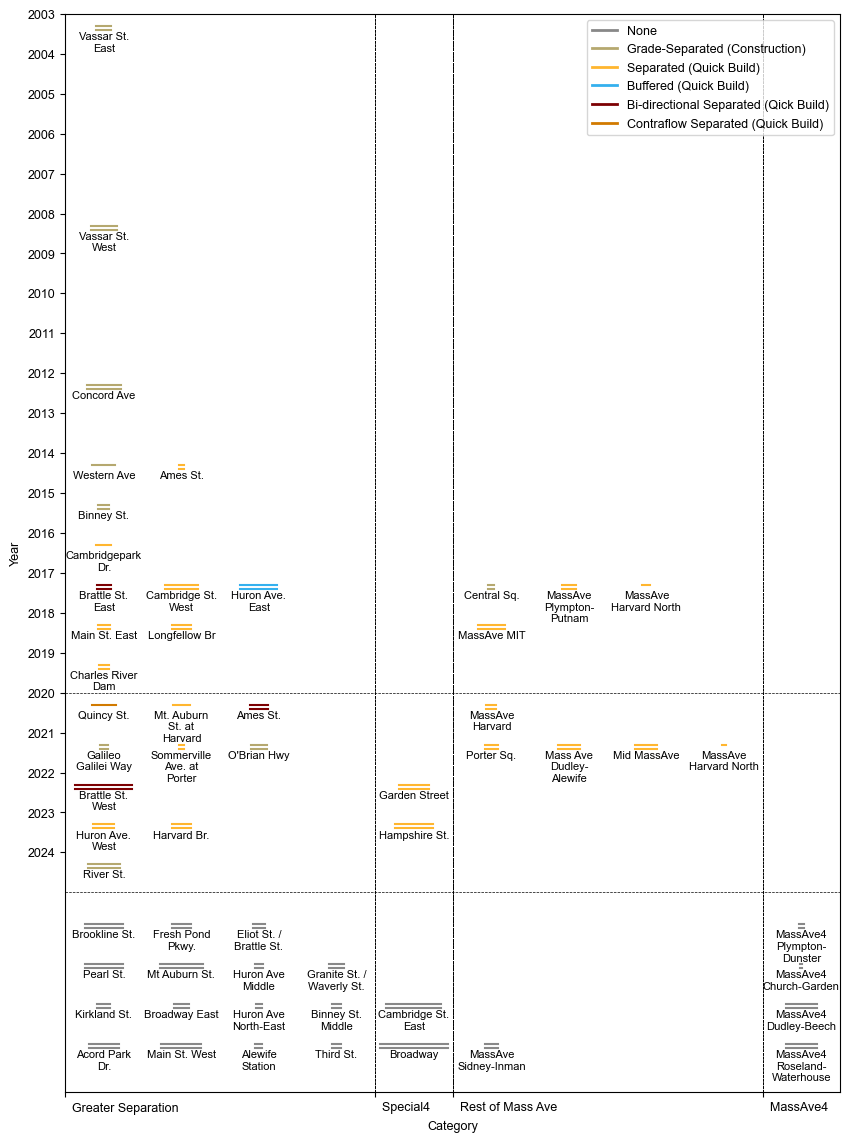

In [21]:
# PLOT

# initialization and settings
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'arial'
fig, ax = plt.subplots(figsize=(10, 14))
ax.set_ylabel('Year')
ax.set_xlabel('Category')
ax.set_ylim([2003, 2030])
ax.set_xlim([0, 10])

# paint project graphics onto the plot
for index, project in projects_with_cat.iterrows():
    marker_width = project['length_m'] / 2500
    for direction in [0,1]:
        offset = 0.1 * direction
        ax.add_line(
            Line2D(
                [project['x'] - marker_width / 2, project['x'] + marker_width / 2],
                [project['y'] + offset, project['y'] + offset],
                color=project['bike_facility_color'],
                lw=1.5, label='One'
            )
        )
        if project['only_one_direction'] == True:
            break

# paint project labels
for i, label in enumerate(projects_with_cat['name']):
    text = '\n'.join(
            textwrap.wrap(
                textwrap.shorten(
                    label, 30, placeholder='...'
                ),
                width=13
            )
        )
    coords_xy = (
        projects_with_cat['x'][i]+0,
        projects_with_cat['y'][i],
    )
    ax.annotate(
        text, coords_xy,
        textcoords="offset points",
        xytext=(0, -4),
        ha='center', va='top', fontsize='8'
    )
    
# paint border lines between categories
for index, row in projects_with_cat.iterrows():
    if index in {'none', 'other', 'mass_ave_rest', 'mass_ave_4'}:
        ax.axvline(x=row['x_min'], color='gray', linestyle=':', label='Threshold', linewidth=0.3)
    else:
        ax.axvline(x=row['x_min'], color='black', linestyle='--', label='Threshold', linewidth=0.5)
        
# paint border lines between epochs
y_milestones = {2020: 'Amended CSO', 2025: 'Now'}
for y, name in y_milestones.items():
    ax.axhline(y=y, color='black', linestyle='--', linewidth=0.5)
    
# set x ticks (categories)
ax.set_xticks(
    categories['x_min'],
    # category names as wrapped texts
    '  ' + categories['fullname'],
    va='top', ha='left'
) 

# set y ticks (years)
y_ticks = range(int(min(projects_gdf['year_from'])), 2025)
ax.set_yticks(y_ticks)
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# legend
legend_df = pd.DataFrame(
    projects_with_cat
        .groupby('bike_facility')
        .agg({
            'bike_facility_color': 'first',
            'bike_facility_name': 'first',
        })
)
legend_elements = [
    Line2D([0], [0], color=row['bike_facility_color'], lw=2, label=row['bike_facility_name'])
    for index, row
    in legend_df.iterrows()
]
ax.legend(handles=legend_elements, loc='upper right')


plt.savefig(
    os.path.join(process_path, 'scatter_plot_custom_dpi.png'),
    dpi=300,
    bbox_inches='tight'
) 

In [7]:
if 0:
    # CATEGORIZE PROJECTS ACCORDING TO INTERVIEW MATRIX
    
    #CHECK IF LINKS ARE PART OF THE PLANNED NETWORK
    
    # Load the Cycling Safety Ordinance (CSO) network
    cso_gpkg = snman.io.import_geofile_to_gdf(
        os.path.join(inputs_path, 'usa/cambridge/CSO/cso.gpkg'),
        crs=CRS_internal
    )
    
    # Match the SCO onto the street graph
    snman.enrichment.match_linestrings(
        G, cso_gpkg,
        [{'source_column': 'type', 'target_column': '_cso_type', 'agg': 'list'}],
        remove_short_overlaps=True,
        remove_sidetrips=False,
        max_dist=400, max_dist_init=100, max_lattice_width=5
    )
    
    for uvk, data in G.edges.items():
        if 'mass_ave_4' in data['_cso_type_forward'] + data['_cso_type_backward']:
            data['cso_type'] = 'mass_ave_4'
        elif 'mass_ave_rest' in data['_cso_type_forward'] + data['_cso_type_backward']:
            data['cso_type'] = 'mass_ave_rest'
        elif 'special_4' in data['_cso_type_forward'] + data['_cso_type_backward']:
            data['cso_type'] = 'special_4'
        elif 'other' in data['_cso_type_forward'] + data['_cso_type_backward']:
            data['cso_type'] = 'other'
        else:
            data['cso_type'] = 'none'
        

In [8]:
if 0:
    # CHECK IF SEPARATED INFRASTRUCTURE IS IMPLEMENTED
    factypes_separated_bikelanes = {4,8,84,83}
    for uvk, data in G.edges.items():
        # Check if separated bike lanes are implemented
        #separated_bikelanes_implemented = factypes_separated_bikelanes in data['_factype_steps_2023_forward']
        #print([data['_factype_' + key + '_forward'] for key in lane_keys])
        #print(data['_factype_steps_2023_forward'])
        results = []
        for key in ['_factype_steps_2023_forward', '_factype_steps_2023_backward']:
            facilities = data[key]
            # unstringify the list
            facilities = facilities.strip('][').split(',')
            facilities = [int(float(facility)) for facility in facilities if len(facility) > 0]
            print(facilities)
            direction_has_separated_bikelanes = len(set(facilities) & factypes_separated_bikelanes) > 0
            #print(set(facilities) & factypes_separated_bikelanes)
            results += [direction_has_separated_bikelanes]
            
        data['has_separated_bikelanes'] = any(results)
        if all(results):
            data['has_separated_bikelanes'] = 'both_directions'
        elif results[0] == True:
            data['has_separated_bikelanes'] = 'only_forward'
        elif results[1] == True:
            data['has_separated_bikelanes'] = 'only_backward'
        else:
            data['has_separated_bikelanes'] = 'no'
        
        